In [15]:
import scanpy as sc
from perturbench.data.datasplitter import PerturbationDataSplitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_ctx_scprocess_no+ctrl.h5ad')


In [3]:
boli

AnnData object with n_obs × n_vars = 21700 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_clean', 'condition', 'cell_type', 'cell_class'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [4]:
boli.obs["predicted.subclass"].value_counts()

predicted.subclass
L6 CT CTX     7860
L5 PT CTX     3710
L5 NP CTX     2755
L6 IT CTX     2544
L5 IT CTX     1939
Pvalb         1317
Sst            838
L3 RSP-ACA     370
L6b CTX        367
Name: count, dtype: int64

In [41]:
boli.obs["condition"].value_counts()

condition
BCL11B    3546
TRIO      2816
DAB1      2687
TBR1      2132
ctrl      1781
RB1CC1    1616
SATB2     1543
HERC1     1462
ANK3      1169
XPO7      1041
CUL1       959
CX3CL1     948
Name: count, dtype: int64

In [8]:
boli.obs["cell_class"].value_counts()

cell_class
ctL6     8227
itRSP    4853
PT       3710
NP       2755
inhib    2155
Name: count, dtype: int64

In [5]:
import yaml

# Load from a YAML file
with open("/gpfs/home/asun/jin_lab/perturbench/src/perturbench/src/perturbench/configs/data/splitter/saved_split.yaml", "r") as f:
    cfg = yaml.safe_load(f)

print(type(cfg))   # usually a dict
cfg["split_path"] = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-12_05-09-18_boli_qual_high_amt_high/train_test_split.csv"
print(cfg)

<class 'dict'>
{'split_path': '/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-12_05-09-18_boli_qual_high_amt_high/train_test_split.csv'}


In [6]:
from omegaconf import OmegaConf
splitter_config = OmegaConf.create(cfg)

In [7]:
split_dict = PerturbationDataSplitter.split_dataset(
    splitter_config,
    boli.obs.copy(),
    perturbation_key='condition',
    perturbation_combination_delimiter="+",
    perturbation_control_value='ctrl',
)
split_dict

{'train': array([    3,     5,    10, ..., 21696, 21698, 21699]),
 'val': array([    0,     2,    18, ..., 21683, 21690, 21697]),
 'test': array([    1,     4,     6, ..., 21678, 21682, 21687])}

In [40]:
perturbations_to_remove = ["XPO7", "RB1CC1", "SATB2", "CX3CL1", "CUL1", "TBR1"]
df_100_5 = boli.obs[~boli.obs["condition"].isin(perturbations_to_remove)]

balanced_transfer_splitter = PerturbationDataSplitter(
    df_100_5,
    perturbation_key='condition',
    covariate_keys=['cell_class'],
    perturbation_control_value='ctrl',
)
balanced_transfer_splitter


In [36]:
balanced_transfer_splitter = PerturbationDataSplitter(
    boli.obs.copy(),
    perturbation_key='condition',
    covariate_keys=['cell_class'],
    perturbation_control_value='ctrl',
)
balanced_transfer_splitter

In [42]:
seed_id = 1
balanced_transfer_split = balanced_transfer_splitter.split_covariates(
    seed=seed_id, 
    print_split=True, 
    #max_heldout_covariates=3, ## Maximum number of held out covariates (in this case cell types)
    max_heldout_fraction_per_covariate=0.6, ## Maximum fraction of perturbations held out per covariate
    max_heldout_covariates = 3,
    #test_fraction = 0.5,
)

Split summary: 
            train  val  test
('itRSP',)      3    2     3
('inhib',)      5    1     1
('PT',)         4    2     2
('ctL6',)       2    3     3
('NP',)         4    2     2


/gpfs/group/jin/asun/perturbench/src/perturbench/src/perturbench/data/datasplitter.py:340: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cov_keys, df in self.obs_dataframe.groupby(self.covariate_keys):
/gpfs/group/jin/asun/perturbench/src/perturbench/src/perturbench/data/datasplitter.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pert_key, df in self.obs_dataframe.groupby([self.perturbation_key]):
/gpfs/group/jin/asun/perturbench/src/perturbench/src/perturbench/data/datasplitter.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [31]:
# Define which perturbations to add back
perturbations_to_include = ["CX3CL1", "CUL1", "TBR1"]

# Get the rows from df_100 that match perturbations_to_include
rows_to_add = boli.obs[boli.obs["condition"].isin(perturbations_to_include)].copy()

# Set transfer_split_seed1 to "train" for these rows
rows_to_add["transfer_split_seed1"] = "train"

# Combine df_100_5 with the modified rows
df_100_8 = pd.concat([df_100_5, rows_to_add], ignore_index=False)

In [43]:
df_100_5

,orig.ident,nCount_RNA,nFeature_RNA,seurat_clusters,Assign,scds,cxds,bcds,Sample,nCount_refAssay,...,BioSamp,CT2,ForPlot,Remove,active_ident,Assign_clean,condition,cell_type,cell_class,transfer_split_seed1
batch1_samp1_chan1_AAACCTGAGACAAAGG-1,batch1,6831,2953,7,Bcl11b_0,1.323674,28996.749458,0.880423,batch1_samp1_chan1,6831,...,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Bcl11b_0,False,7,Bcl11b,BCL11B,L5_PT_CTX,PT,test
batch1_samp1_chan1_AAACCTGAGGCCGAAT-1,batch1,6016,2767,21,Bcl11b_0,0.487555,9829.195327,0.337222,batch1_samp1_chan1,6016,...,batch1_samp1,029 L6b CTX Glut,batch1_samp1_Bcl11b_0,False,21,Bcl11b,BCL11B,L6b_CTX,ctL6,test
batch1_samp1_chan1_AAACCTGCAGGGCATA-1,batch1,2321,1423,3,Trio_0,0.129805,8054.464267,0.009807,batch1_samp1_chan1,2321,...,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Trio_0,False,3,Trio,TRIO,L6_CT_CTX,ctL6,train
batch1_samp1_chan1_AAACCTGCATAACCTG-1,batch1,6090,2799,16,Ank3_0,0.412240,21430.397346,0.091283,batch1_samp1_chan1,6090,...,batch1_samp1,022 L5 ET CTX Glut,batch1_samp1_Ank3_0,False,16,Ank3,ANK3,L5_PT_CTX,PT,train
batch1_samp1_chan1_AAACCTGGTGCTTCTC-1,batch1,3031,1724,3,Trio_0,0.123214,6786.097563,0.022041,batch1_samp1_chan1,3031,...,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Trio_0,False,3,Trio,TRIO,L6_CT_CTX,ctL6,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch2_mouse3_chan7_TTTGGTTGTACACCGC-1,batch2,4787,2421,3,NT_0,0.111513,464.022903,0.070833,batch2_mouse3_chan7,4787,...,batch2_mouse3,030 L6 CT CTX Glut,batch2_mouse3_NT_0,False,3,ctrl,ctrl,L6_CT_CTX,ctL6,train
batch2_mouse3_chan7_TTTGTCAAGGACGAAA-1,batch2,5163,2622,11,Bcl11b_0,0.281308,2976.912848,0.017014,batch2_mouse3_chan7,5163,...,batch2_mouse3,005 L5 IT CTX Glut,batch2_mouse3_Bcl11b_0,False,11,Bcl11b,BCL11B,L5_IT_CTX,itRSP,train
batch2_mouse3_chan7_TTTGTCAAGGTTACCT-1,batch2,6878,2993,9,Bcl11b_0,0.120376,1230.309186,0.011879,batch2_mouse3_chan7,6878,...,batch2_mouse3,052 Pvalb Gaba,batch2_mouse3_Bcl11b_0,False,9,Bcl11b,BCL11B,Pvalb,inhib,train
batch2_mouse3_chan7_TTTGTCAAGTCAAGCG-1,batch2,12165,3909,6,Dab1_0,0.556719,5738.395435,0.045919,batch2_mouse3_chan7,12165,...,batch2_mouse3,022 L5 ET CTX Glut,batch2_mouse3_Dab1_0,False,6,Dab1,DAB1,L5_PT_CTX,PT,val


In [10]:
# start with all rows labeled None
balanced_transfer_splitter.obs_dataframe["transfer_split_seed1"] = None  

# fill according to the split_dict
for split_name, idxs in split_dict.items():
    balanced_transfer_splitter.obs_dataframe.iloc[idxs, balanced_transfer_splitter.obs_dataframe.columns.get_loc("transfer_split_seed1")] = split_name

In [11]:
print(balanced_transfer_splitter.obs_dataframe.groupby(["condition", "transfer_split_seed1", "cell_class"]).size())

condition  transfer_split_seed1  cell_class
ANK3       test                  NP              0
                                 PT              0
                                 ctL6          489
                                 inhib           0
                                 itRSP         283
                                              ... 
ctrl       val                   NP             57
                                 PT             64
                                 ctL6          184
                                 inhib          54
                                 itRSP          86
Length: 180, dtype: int64


/tmp/ipykernel_30927/2727442397.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(balanced_transfer_splitter.obs_dataframe.groupby(["condition", "transfer_split_seed1", "cell_class"]).size())


In [16]:
### identify last training splits
df_100 = balanced_transfer_splitter.obs_dataframe

# Start with df_100_5 (which excludes perturbations_to_remove)
perturbations_to_remove = ["XPO7", "RB1CC1", "SATB2", "CX3CL1", "CUL1", "TBR1"]
df_100_5 = df_100[~df_100["condition"].isin(perturbations_to_remove)]

# Define which perturbations to add back
perturbations_to_include = ["CX3CL1", "CUL1", "TBR1"]

# Get the rows from df_100 that match perturbations_to_include
rows_to_add = df_100[df_100["condition"].isin(perturbations_to_include)].copy()

# Set transfer_split_seed1 to "train" for these rows
rows_to_add["transfer_split_seed1"] = "train"

# Combine df_100_5 with the modified rows
df_100_8 = pd.concat([df_100_5, rows_to_add], ignore_index=True)

In [41]:
#count_long = balanced_transfer_splitter.obs_dataframe.groupby(["cell_class2", "condition", f"transfer_split_seed{seed_id}"]).size().reset_index(name = "count")
count_long = balanced_transfer_splitter.obs_dataframe.groupby(["condition", "transfer_split_seed1", "cell_class"]).size().reset_index(name = "count")

#cell_counts_all = count_long.pivot(index = ["cell_class2", "condition"], columns = f"transfer_split_seed{seed_id}", values = "count" ).reset_index()
cell_counts_all = count_long.pivot(index = ["cell_class", "condition"], columns = "transfer_split_seed1", values = "count" ).reset_index()

cell_counts_all.columns.name = ""
filtered = cell_counts_all.dropna(axis=0, how="all", subset=cell_counts_all.columns[2:])
cell_classes = filtered["cell_class"].unique()
n_cols = 3
n_rows = (len(cell_classes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, cell_class in enumerate(cell_classes):
    ax = axes[i]
    subset = filtered[filtered["cell_class"] == cell_class].set_index("condition")
    subset = subset.drop(columns="cell_class")
    subset = subset.fillna(0)
    data = subset.values

    im = ax.imshow(data, aspect="auto", cmap="viridis")
    ax.set_title(cell_class)
    ax.set_xticks(np.arange(subset.shape[1]))
    ax.set_xticklabels(subset.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(subset.shape[0]))
    ax.set_yticklabels(subset.index)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            value = data[y, x]
            if not np.isnan(value):
                ax.text(x, y, int(value), ha="center", va="center", color="white" if value < data.max() / 2 else "black")

    fig.colorbar(im, ax=ax, shrink=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

KeyError: 'transfer_split_seed1'

In [23]:
df

NameError: name 'df' is not defined

In [27]:
import pandas as pd

def stratified_subsample(df, frac, group_keys, random_state=42):
    """
    Subsample each unique group to a given fraction.

    Parameters
    ----------
    df : pd.DataFrame
        Your input dataframe.
    frac : float
        Fraction of rows to sample per group.
    group_keys : list[str]
        Column names to group by.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Subsampled dataframe.
    """
    return (
        df.groupby(group_keys, group_keys=False, sort=False)
          .apply(lambda g: g.sample(frac=frac, random_state=random_state))
    )

# Example usage
group_cols = ["condition", "cell_class", "transfer_split_seed1"]

df_60 = stratified_subsample(balanced_transfer_splitter.obs_dataframe, frac=0.6, group_keys=group_cols, random_state=1)
df_20 = stratified_subsample(balanced_transfer_splitter.obs_dataframe, frac=0.2, group_keys=group_cols, random_state=2)

print("60% subsample:", df_60.shape)
print("20% subsample:", df_20.shape)

/tmp/ipykernel_28902/3269612138.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_keys, group_keys=False, sort=False)
/tmp/ipykernel_28902/3269612138.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=frac, random_state=random_state))
/tmp/ipykernel_28902/3269612138.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

60% subsample: (13018, 25)
20% subsample: (4340, 25)


/tmp/ipykernel_28902/3269612138.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=frac, random_state=random_state))


In [29]:
import pandas as pd

def stratified_subsample_train(df, frac, group_keys, split_col="transfer_split_seed1", train_label="train", random_state=42):
    """
    Subsample only the training set rows, stratified by group_keys.
    Validation and test rows are kept unchanged.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with split assignments.
    frac : float
        Fraction of training rows to sample per group.
    group_keys : list[str]
        Column names to group by (e.g., condition, cell_class).
    split_col : str
        Column indicating train/val/test split.
    train_label : str
        Value in split_col corresponding to training rows.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Dataframe with downsampled training rows and unchanged val/test.
    """
    # Split by assignment
    train_df = df[df[split_col] == train_label]
    others_df = df[df[split_col] != train_label]

    # Stratified downsample of train
    train_down = (
        train_df.groupby(group_keys, group_keys=False, sort=False)
        .apply(lambda g: g.sample(frac=frac, random_state=random_state))
    )

    # Combine train + others
    return pd.concat([train_down, others_df]).sort_index()

In [30]:
# Example usage
group_cols = ["condition", "cell_class", "transfer_split_seed1"]

df_60 = stratified_subsample_train(balanced_transfer_splitter.obs_dataframe, frac=0.6, group_keys=group_cols, random_state=1)
df_20 = stratified_subsample_train(balanced_transfer_splitter.obs_dataframe, frac=0.2, group_keys=group_cols, random_state=2)

print("60% subsample:", df_60.shape)
print("20% subsample:", df_20.shape)

60% subsample: (16994, 25)
20% subsample: (12291, 25)


/tmp/ipykernel_28902/2667168544.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(group_keys, group_keys=False, sort=False)
/tmp/ipykernel_28902/2667168544.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=frac, random_state=random_state))
/tmp/ipykernel_28902/2667168544.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

In [28]:
balanced_transfer_splitter.obs_dataframe

,orig.ident,nCount_RNA,nFeature_RNA,seurat_clusters,Assign,scds,cxds,bcds,Sample,nCount_refAssay,...,BioSamp,CT2,ForPlot,Remove,active_ident,Assign_clean,condition,cell_type,cell_class,transfer_split_seed1
batch1_samp1_chan1_AAACCTGAGACAAAGG-1,batch1,6831,2953,7,Bcl11b_0,1.323674,28996.749458,0.880423,batch1_samp1_chan1,6831,...,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Bcl11b_0,False,7,Bcl11b,BCL11B,L5_PT_CTX,PT,val
batch1_samp1_chan1_AAACCTGAGGCCGAAT-1,batch1,6016,2767,21,Bcl11b_0,0.487555,9829.195327,0.337222,batch1_samp1_chan1,6016,...,batch1_samp1,029 L6b CTX Glut,batch1_samp1_Bcl11b_0,False,21,Bcl11b,BCL11B,L6b_CTX,ctL6,test
batch1_samp1_chan1_AAACCTGCACGGTAAG-1,batch1,8125,3272,6,Xpo7_0,0.330917,16108.872658,0.089554,batch1_samp1_chan1,8125,...,batch1_samp1,022 L5 ET CTX Glut,batch1_samp1_Xpo7_0,False,6,Xpo7,XPO7,L5_PT_CTX,PT,val
batch1_samp1_chan1_AAACCTGCACTATCTT-1,batch1,5713,2476,21,Xpo7_0,0.557018,17380.257353,0.294270,batch1_samp1_chan1,5713,...,batch1_samp1,029 L6b CTX Glut,batch1_samp1_Xpo7_0,False,21,Xpo7,XPO7,L6b_CTX,ctL6,train
batch1_samp1_chan1_AAACCTGCAGGGCATA-1,batch1,2321,1423,3,Trio_0,0.129805,8054.464267,0.009807,batch1_samp1_chan1,2321,...,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Trio_0,False,3,Trio,TRIO,L6_CT_CTX,ctL6,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch2_mouse3_chan7_TTTGTCAAGTCAAGCG-1,batch2,12165,3909,6,Dab1_0,0.556719,5738.395435,0.045919,batch2_mouse3_chan7,12165,...,batch2_mouse3,022 L5 ET CTX Glut,batch2_mouse3_Dab1_0,False,6,Dab1,DAB1,L5_PT_CTX,PT,train
batch2_mouse3_chan7_TTTGTCACACCTCGTT-1,batch2,6791,3041,2,Rb1cc1_0,0.251665,2416.861376,0.037137,batch2_mouse3_chan7,6791,...,batch2_mouse3,004 L6 IT CTX Glut,batch2_mouse3_Rb1cc1_0,False,2,Rb1cc1,RB1CC1,L6_IT_CTX,itRSP,train
batch2_mouse3_chan7_TTTGTCAGTCATCGGC-1,batch2,11147,3746,6,Bcl11b_0,0.392281,3724.467360,0.060940,batch2_mouse3_chan7,11147,...,batch2_mouse3,022 L5 ET CTX Glut,batch2_mouse3_Bcl11b_0,False,6,Bcl11b,BCL11B,L5_PT_CTX,PT,val
batch2_mouse3_chan7_TTTGTCAGTCGAACAG-1,batch2,4191,2209,3,Rb1cc1_0,0.166137,1647.767477,0.020339,batch2_mouse3_chan7,4191,...,batch2_mouse3,030 L6 CT CTX Glut,batch2_mouse3_Rb1cc1_0,False,3,Rb1cc1,RB1CC1,L6_CT_CTX,ctL6,train


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_counts(df, cell_line_col="cell_line", gene_col="gene", seed_col="transfer_split_seed1"):
    """
    Make heatmaps of counts per (cell_line, gene) × seed from a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with at least [cell_line_col, gene_col, seed_col].
    cell_line_col : str, default "cell_line"
        Column containing cell line identifiers.
    gene_col : str, default "gene"
        Column containing gene identifiers.
    seed_col : str, default "transfer_split_seed1"
        Column containing split/seed values.

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : np.ndarray of Axes
    """
    # counts
    count_long = (
        df.groupby([gene_col, seed_col, cell_line_col])
        .size()
        .reset_index(name="count")
    )

    # pivot to wide format
    cell_counts_all = count_long.pivot(
        index=[cell_line_col, gene_col],
        columns=seed_col,
        values="count"
    ).reset_index()

    cell_counts_all.columns.name = ""

    # drop rows with all NaN counts
    filtered = cell_counts_all.dropna(
        axis=0,
        how="all",
        subset=cell_counts_all.columns[2:]
    )

    cell_classes = filtered[cell_line_col].unique()
    n_cols = 2
    n_rows = (len(cell_classes) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, cell_class in enumerate(cell_classes):
        ax = axes[i]
        subset = (
            filtered[filtered[cell_line_col] == cell_class]
            .set_index(gene_col)
            .drop(columns=cell_line_col)
            .fillna(0)
        )
        data = subset.values

        im = ax.imshow(data, aspect="auto", cmap="viridis")
        ax.set_title(str(cell_class))
        ax.set_xticks(np.arange(subset.shape[1]))
        ax.set_xticklabels(subset.columns, rotation=45, ha="right")
        ax.set_yticks(np.arange(subset.shape[0]))
        ax.set_yticklabels(subset.index)

        # annotate each cell
        for y in range(data.shape[0]):
            for x in range(data.shape[1]):
                value = data[y, x]
                ax.text(
                    x, y, int(value),
                    ha="center", va="center",
                    color="white" if value < data.max() / 2 else "black",
                    fontsize=8
                )

        fig.colorbar(im, ax=ax, shrink=0.6)

    # delete unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    return fig, axes

/tmp/ipykernel_30927/1491118139.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([gene_col, seed_col, cell_line_col])


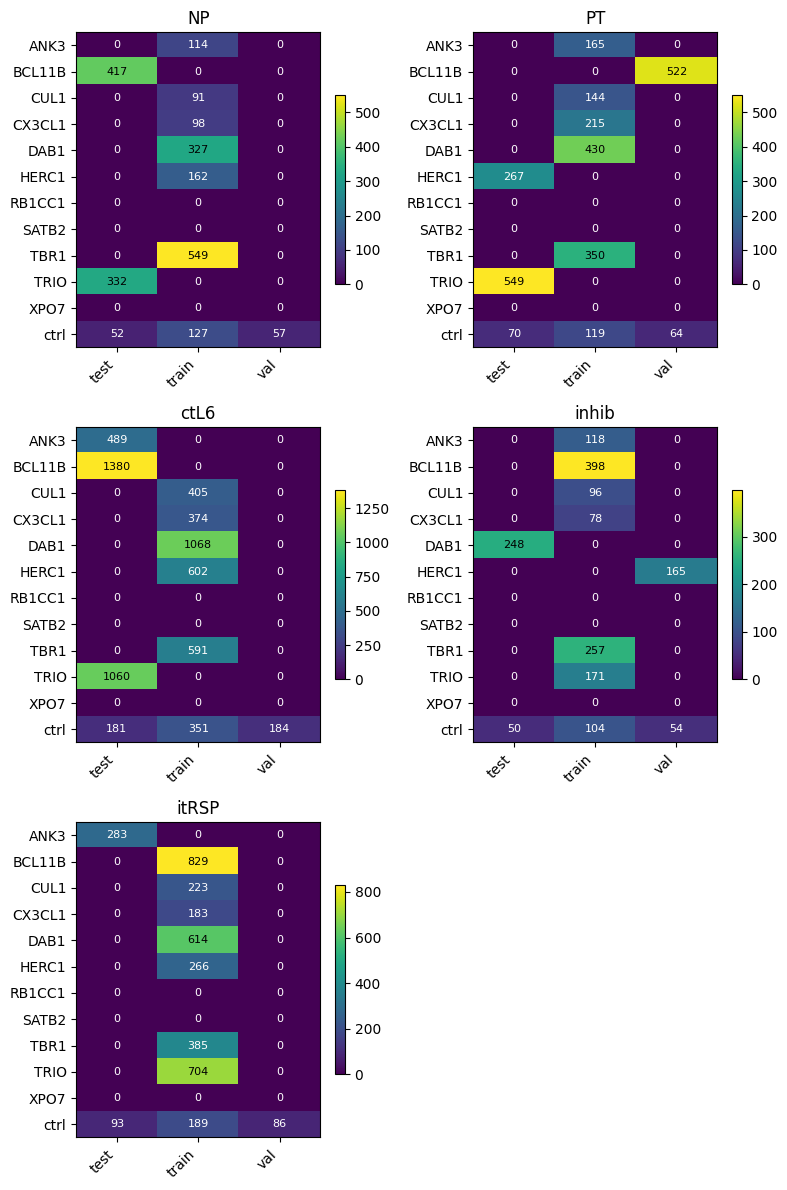

(<Figure size 800x1200 with 10 Axes>,
 array([<Axes: title={'center': 'NP'}>, <Axes: title={'center': 'PT'}>,
        <Axes: title={'center': 'ctL6'}>,
        <Axes: title={'center': 'inhib'}>,
        <Axes: title={'center': 'itRSP'}>, <Axes: >], dtype=object))

In [18]:
plot_counts(df_100_8, cell_line_col="cell_class", gene_col="condition", seed_col="transfer_split_seed1")

In [38]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_60[["transfer_split_seed1"]].copy()

# write both the index and the column
out.to_csv("boli_df_60_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [39]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_20[["transfer_split_seed1"]].copy()

# write both the index and the column
out.to_csv("boli_df_20_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [40]:
adata_60 = boli[df_60.index].copy()
adata_20 = boli[df_20.index].copy()
adata_60.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_60.h5ad")
adata_20.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_20.h5ad")

# Remove Perturbations

In [43]:
df_100 = balanced_transfer_splitter.obs_dataframe

In [44]:
boli.obs["condition"].value_counts()

condition
BCL11B    3546
TRIO      2816
DAB1      2687
TBR1      2132
ctrl      1781
RB1CC1    1616
SATB2     1543
HERC1     1462
ANK3      1169
XPO7      1041
CUL1       959
CX3CL1     948
Name: count, dtype: int64

In [45]:
# Suppose you have a list of perturbations to remove
perturbations_to_remove = ["XPO7", "RB1CC1", "SATB2"]

# Drop any row whose condition is in that list
df_100_8 = df_100[~df_100["condition"].isin(perturbations_to_remove)]
df_60_8 = df_60[~df_60["condition"].isin(perturbations_to_remove)]
df_20_8 = df_20[~df_20["condition"].isin(perturbations_to_remove)]

In [46]:
# Suppose you have a list of perturbations to remove
perturbations_to_remove = ["XPO7", "RB1CC1", "SATB2", "CX3CL1", "CUL1", "TBR1"]

# Drop any row whose condition is in that list
df_100_5 = df_100[~df_100["condition"].isin(perturbations_to_remove)]
df_60_5 = df_60[~df_60["condition"].isin(perturbations_to_remove)]
df_20_5 = df_20[~df_20["condition"].isin(perturbations_to_remove)]

In [47]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_100_8[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_100_8_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [48]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_60_8[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_60_8_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [49]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_20_8[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_20_8_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [50]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_100_5[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_100_5_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [51]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_60_5[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_60_5_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [52]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_20_5[["transfer_split_seed1"]].copy()
# write both the index and the column
out.to_csv("boli_df_20_5_train_downsample_only_split.csv", index=True, index_label="cell_barcode", header=False)

In [58]:
adata_100_8 = boli[df_100_8.index].copy()
adata_100_5 = boli[df_100_5.index].copy()
adata_100_8.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_100_8.h5ad")
adata_100_5.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_100_5.h5ad")

In [59]:
adata_60_8 = boli[df_60_8.index].copy()
adata_60_5 = boli[df_60_5.index].copy()
adata_60_8.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_60_8.h5ad")
adata_60_5.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_60_5.h5ad")

In [ ]:
adata_20_8 = boli[df_20_8.index].copy()
adata_20_5 = boli[df_20_5.index].copy()
adata_20_8.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_20_8.h5ad")
adata_20_5.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_subset_seed2_train_downsample_only_20_5.h5ad")